# Tutorial análisis de patrones 
## Luis Fernando Torres Torres 

En el presente informe se muestra y se explica como es la metodología de cada una de las etapas que componen el análisis de patrones.

<img src="metodologia.png">

Se familiariza con cada una de las etapas, por medio de un ejercicio práctico enfocado en el procesamiento digital de señales de voz. Se implementa la primera etapa que consiste en la adquisición de los datos, luego se realiza el acondicionamiento del audio en la etapa de preprocesado para ser analizados adecuadamente, posteriormente se hace la extracción de características donde se obtienen representaciones de los datos adquiridos.

In [1]:
pip install sklearn 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
#Librerias a usar 
import numpy as np
from scipy.io.wavfile import read # libreria para lectura de archivos de audio
from IPython.display import Audio # para escuchar Audio
import matplotlib.pyplot as plt

#Clasificación
import sklearn 
from sklearn.decomposition import PCA #Libreria para aplicar PCA
from sklearn.preprocessing import StandardScaler # Libreria para normalizar datos
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA #Libreria para aplicar LDA
from sklearn.model_selection import train_test_split #Dividir los datos 
from sklearn.neighbors import KNeighborsClassifier #Libreria para vecinos cercanos 
from sklearn import svm #Maquina vectorial de soporte
from sklearn.inspection import DecisionBoundaryDisplay #Para imprimir decisión de SVM
from sklearn.model_selection import  KFold # Cross validation K-fold
from sklearn.model_selection import GridSearchCV # Malla de busqueda 
from scipy import stats as st #Para sacar la moda 

#Metricas
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix #Matriz de confusión
from sklearn.metrics import accuracy_score # Para mirar el puntaje de precisión
from sklearn.metrics import recall_score # Sensibilidad
from sklearn.metrics import precision_score #Precisión

#Scores, AUC , y ROC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns

In [2]:
def graficar(x,y,x_label,y_label,titulo,tamanio=(10,4)):
    """
    Función para graficar datos
    inputs:
        x: Array de puntos del eje x
        y: Array de puntos del eje y
        x_label: label del eje x
        y_label: label para el eje y
        titulo: titulo de la grafica
        
    """
    plt.figure(figsize=tamanio)
    plt.plot(x,y)
    plt.xlabel(x_label,fontsize=12)
    plt.ylabel(y_label,fontsize=12)
    plt.title(titulo,fontsize=16)
    plt.show()

## Pre-procesamiento

Para trabajar con señales de vos, es necesario adecuar la señal para obtener una información mejor representada. Para esto se debe eliminar el nivel DC que puede traer la señal desde el momento de adquisición de los datos, y esto se hace restando el promedio de la señal en cada punto o instante de tiempo de ella. Por otra parte, para visualizar mejor los datos es importante normalizar las amplitudes, es decir, hacer que estos valores estén entre -1 y 1, para esto se divide cada valor de la señal sin nivel DC por el valor máximo de amplitud en valor absoluto. De esta manera se obtiene una señal centrada y con valores más fáciles de tratar.

In [3]:
file_audio=('audio.wav') # Ruta del archivo con la senal
fs, x=read(file_audio) # Cargar el archivo
t=np.arange(0, float(len(x)), 1.0) # Vector de tiempo sin normalizar 

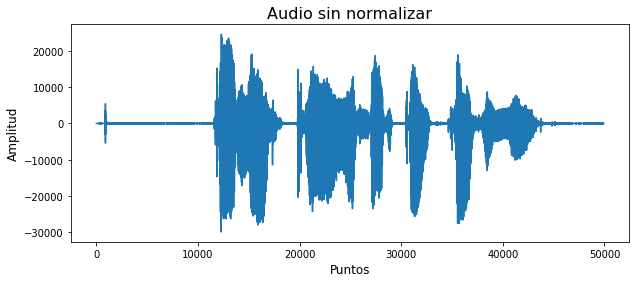

In [4]:
#Gráfica sin normalizar
graficar(t,x,"Puntos","Amplitud","Audio sin normalizar")
Audio(x, rate=fs)

In [5]:
def normalizar(fs,x):
    """
    Función para normalizar audio
    inputs:
        fs:Frecuencia de muestreo del audio
        x: Array de la señal original
    outputs:
        x: Array de la señal normalizada
        t: Array temporal normalizado
    """
    x=x-np.mean(x)
    x=x/float(max(abs(x))) # escala la amplitud de la senal 
    t=np.arange(0, float(len(x))/fs, 1.0/fs) # Vector de tiempo normalizado 
    return x,t

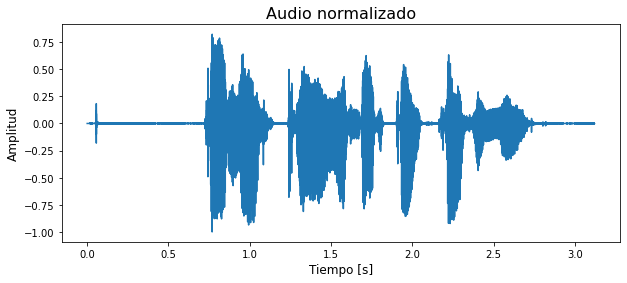

In [6]:
#Gráfica de señal normalizada
x,t=normalizar(fs,x) #Normalizar audio
graficar(t,x,"Tiempo [s]","Amplitud","Audio normalizado")
Audio(x, rate=fs)

Cabe resaltar que normalizar un audio, sirve solo para visualizar de manera más organizada la información que contiene de manera gráfica y numérica, ya que el contenido no cambia en nada.

Luego entonces se procede a realizar el proceso de enventanado, es decir, tomar pequeñas porciones del audio, para obtener información en pequeños segmentos que sean más sencillos de analizar.

# Extracción de características  

En esta etapa de caracterización se busca extraer diferentes medidas con las que puedan representar los datos obtenidos, Basado en distintas medidas como la energía de la señal, los coeficientes espectrales, o razón de cruce por cero, entre otros. 

Existen varias técnicas para selección de características tales como análisis de componenetes principales (PCA, del inglés Principal Component Analysis), análisis discriminante lineal (LDA, del inglés Linear Discriminant Analysis) las cuales se van a implementar en este documento.

## Principal Component Analysis (PCA)

In [7]:
bajas=np.loadtxt("low_emotions.txt")#Cargar archivo emociones bajas
altas=np.loadtxt("high_emotions.txt")#Cargar archivo emociones altas

#Creación de etiquetas 
labels_bajas=np.zeros((bajas.shape[0],))
labels_altas=np.ones((altas.shape[0],))

print("Dimensión de bajas emociones: ",np.shape(bajas))
print("Dimensión de altas emociones: ",np.shape(altas))

Dimensión de bajas emociones:  (222, 6373)
Dimensión de altas emociones:  (313, 6373)


In [8]:
data= np.concatenate((bajas,altas))
labels_data= np.concatenate((labels_bajas,labels_altas))
print("Dimensión de mi matriz de datos:",np.shape(data))

#Normalizo datos de mi matriz 
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

Dimensión de mi matriz de datos: (535, 6373)


In [9]:
pca = PCA(n_components=2)
pca_transformado= pca.fit_transform(data)
pca_var = pca.explained_variance_ratio_
print(pca_transformado.shape)

(535, 2)


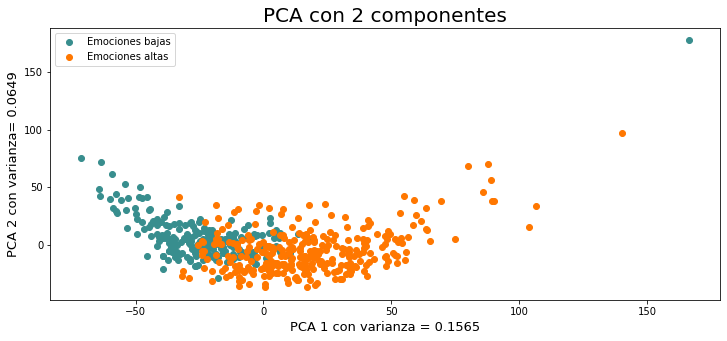

In [10]:
plt.figure(figsize=(12,5))
#plt.scatter(pca_transformado[:,0],pca_transformado[:,1],c=labels_data)
plt.scatter(pca_transformado[:bajas.shape[0],0],pca_transformado[:bajas.shape[0],1],label="Emociones bajas",c="#388E8E")
plt.scatter(pca_transformado[bajas.shape[0]:,0],pca_transformado[bajas.shape[0]:,1],label="Emociones altas",c="#ff7700")
plt.title("PCA con 2 componentes",fontsize=20)
plt.xlabel("PCA 1 con varianza = {}".format(round(pca_var[0],4)),fontsize=13)
plt.ylabel("PCA 2 con varianza= {}".format(round(pca_var[1],4)),fontsize=13)
plt.legend(loc="best")

## Linear Discriminant Analysis (LDA)

In [11]:
lda = LDA(n_components=1)
lda_transformada= lda.fit_transform(data,labels_data)
print(lda_transformada.shape)

(535, 1)


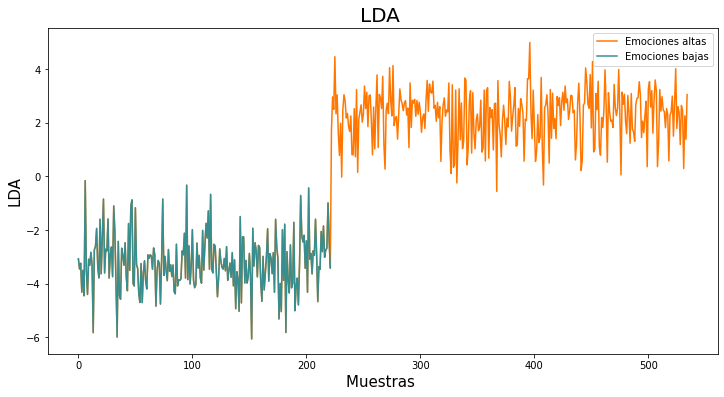

In [12]:
plt.figure(figsize=(12,6))
plt.plot(lda_transformada,c="#ff7700", label="Emociones altas")
plt.xlabel("Muestras ",fontsize=15)
plt.ylabel("LDA",fontsize=15)
plt.plot(lda_transformada[:bajas.shape[0]],c="#388E8E",label="Emociones bajas")
plt.title("LDA ",fontsize=20)
plt.legend(loc="best")
plt.show()


# Clasificación de datos 

## Clasificación por k nearest neighbor (KNN)

In [13]:
#División de los datos para entrenamiento y clasificación
#Adecuar los da datos para clasificacion
X_train, X_test, y_train, y_test = train_test_split(pca_transformado, labels_data, test_size=0.30)

#Normalizar y escalar los datos 
scaler.fit(X_train)# se calcula los vectores de media  y std

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [14]:
#Entrenamiendo por K vecinos más cercanos
classifier = KNeighborsClassifier(n_neighbors=5)

#Genero un mapa con los datos de entrenamiento(datos reales, junto con sus etiquetas)
classifier.fit(X_train, y_train) 

#Testear la data 
y_pred = classifier.predict(X_test)# Evaluo los datos x_test y retorno las etiquetas 

#Valores predichos para imprimir
x_low = X_test[np.where(y_pred == 0)]
x_high = X_test[np.where(y_pred == 1)]

#Valores originales para imprimir 
x_Tlow = X_test[np.where(y_test == 0)]
x_Thigh = X_test[np.where(y_test == 1)]

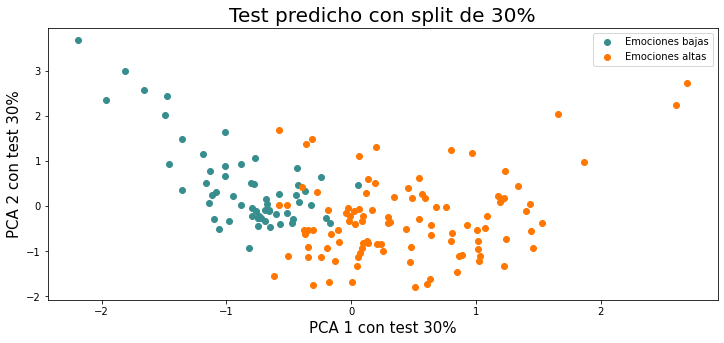

In [16]:
plt.figure(figsize=(12,5))
plt.scatter(x_low[:,0],x_low[:,1],c="#388E8E", label="Emociones bajas")
plt.scatter(x_high[:,0],x_high[:,1],c="#ff7700", label="Emociones altas")
plt.xlabel("PCA 1 con test 30%",fontsize=15)
plt.ylabel("PCA 2 con test 30%",fontsize=15)
plt.title("Test predicho con split de 30%",fontsize=20)
plt.legend()
plt.show()

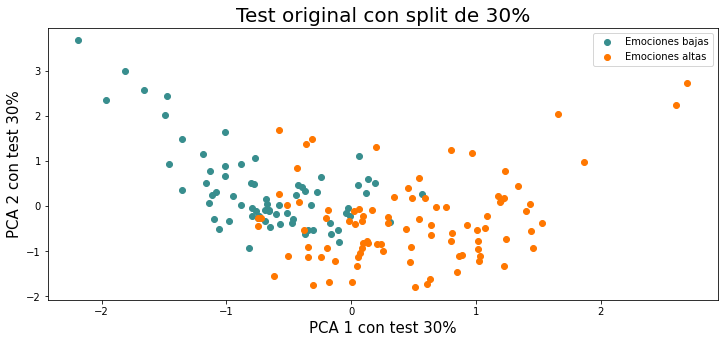

In [17]:
plt.figure(figsize=(12,5))
plt.scatter(x_Tlow[:,0],x_Tlow[:,1],c="#388E8E", label="Emociones bajas")
plt.scatter(x_Thigh[:,0],x_Thigh[:,1],c="#ff7700", label="Emociones altas")
plt.xlabel("PCA 1 con test 30%",fontsize=15)
plt.ylabel("PCA 2 con test 30%",fontsize=15)
plt.title("Test original con split de 30%",fontsize=20)
plt.legend()
plt.show()

In [19]:
def specifity(Matriz):
    """
    La especificidad, por su parte, es la tasa de verdaderos negativos, (“true negative rate”) o TN. 
    Es la proporción entre los casos negativos bien clasificados por el modelo, respecto al total de negativos.
    """
    Especificidad = Matriz[0][0]/(Matriz[0][0]+Matriz[1][0])
    return Especificidad

In [20]:
#Matriz de confución
Matriz_confusion = confusion_matrix(y_test,y_pred)
print("Matriz de confusión:", Matriz_confusion)
# Imprimir precision
Accuracy= accuracy_score(y_test,y_pred)
print("Accuracy: ",Accuracy)
# Recall, sensibilidad
Sensibilidad = recall_score(y_test, y_pred)
print("Sensibilidad: ", Sensibilidad)
#Precisión
Precision = precision_score(y_test, y_pred)
print("Precisión: ",Precision)
#Especificidad
Especificidad = specifity(Matriz_confusion)
print("Especificidad: ", Especificidad)

Matriz de confusión: [[57  8]
 [20 76]]
Accuracy:  0.8260869565217391
Sensibilidad:  0.7916666666666666
Precisión:  0.9047619047619048
Especificidad:  0.7402597402597403


## KNN usando validación cruzada  

In [21]:
#Numero de K-folds a usar
kf = KFold(n_splits=10,shuffle=True)
kf.get_n_splits(pca_transformado)

#Arrays para metricas  
Accuracy=np.array([])
Sensibilidad = np.array([])
Precision=np.array([])
Especificidad = np.array([])

for train_index, test_index in kf.split(pca_transformado):
    #Vector x (datos)
    X_train, X_test = pca_transformado[train_index], pca_transformado[test_index]
    
    #Vector Y (labels)
    y_train, y_test = labels_data[train_index], labels_data[test_index]

    scaler.fit(X_train)# se calcula los vectores de media  y std

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #Clasificador KNN
    classifier = KNeighborsClassifier(n_neighbors=5) 
    
    #Genero un mapa con los datos de entrenamiento(datos reales, junto con sus etiquetas)
    classifier.fit(X_train, y_train) 

    #Testear la data 
    y_pred = classifier.predict(X_test)# Evaluo los datos x_test y retorno las etiquetas 
    
    Accuracy=np.append(Accuracy,accuracy_score(y_test,y_pred))
    Sensibilidad= np.append(Sensibilidad,recall_score(y_test, y_pred))
    Precision = np.append(Precision,precision_score(y_test, y_pred))
    Especificidad=np.append(Especificidad,specifity(confusion_matrix(y_test,y_pred)))

In [22]:
print("El promedio de accuracy: ",np.mean(Accuracy),",La desviasión estandar: ",np.std(Accuracy))
print("El promedio de la sensibilidad: ",np.mean(Sensibilidad),",La desviasión estandar: ",np.std(Sensibilidad))
print("El promedio de Precisión: ",np.mean(Precision),",La desviasión estandar: ",np.std(Precision))
print("El promedio de Especificidad: ",np.mean(Especificidad),",La desviasión estandar: ",np.std(Especificidad))

El promedio de accuracy:  0.8541229909154439 ,La desviasión estandar:  0.04212980259358066
El promedio de la sensibilidad:  0.8652607713637126 ,La desviasión estandar:  0.0541478551950319
El promedio de Precisión:  0.8807034542119931 ,La desviasión estandar:  0.059395837511692834
El promedio de Especificidad:  0.821494643463953 ,La desviasión estandar:  0.03713887717346404


## KNN usando K-fold y Gridsearch

In [23]:
#Numero de K-folds a usar
kf = KFold(n_splits=10,shuffle=True)
kf.get_n_splits(pca_transformado)

#Arrays para metricas  
Accuracy=np.array([])
Sensibilidad = np.array([])
Precision=np.array([])
Especificidad = np.array([])

#Parametro de N vecinos cercanos para malla  de busqueda
parameter_KNN={"n_neighbors":[i for i in range(1,10)]} 

#Array para guardar los N
N=np.array([])

for train_index, test_index in kf.split(pca_transformado):
    #Vector x (datos)
    X_train, X_test = pca_transformado[train_index], pca_transformado[test_index]
    
    #Vector Y (labels)
    y_train, y_test = labels_data[train_index], labels_data[test_index]

    scaler.fit(X_train)# se calcula los vectores de media  y std

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Hago la malla de busqueda
    classifier = GridSearchCV(KNeighborsClassifier(), parameter_KNN)
    
    #Entrenar el modelo para poder encontrar mejor N para KNN
    classifier.fit(X_train, y_train)
    
    #Agregar los N a un array
    N= np.append(N,classifier.best_estimator_.n_neighbors)
    
    #Clasificador KNN
    classifier = KNeighborsClassifier(n_neighbors=classifier.best_estimator_.n_neighbors) 
    
    #Genero un mapa con los datos de entrenamiento(datos reales, junto con sus etiquetas)
    classifier.fit(X_train, y_train) 

    #Testear la data 
    y_pred = classifier.predict(X_test)# Evaluo los datos x_test y retorno las etiquetas 
    
    Accuracy=np.append(Accuracy,accuracy_score(y_test,y_pred))
    Sensibilidad= np.append(Sensibilidad,recall_score(y_test, y_pred))
    Precision = np.append(Precision,precision_score(y_test, y_pred))
    Especificidad=np.append(Especificidad,specifity(confusion_matrix(y_test,y_pred)))

In [24]:
print("El promedio de accuracy: ",np.mean(Accuracy),",La desviasión estandar: ",np.std(Accuracy))
print("El promedio de la sensibilidad: ",np.mean(Sensibilidad),",La desviasión estandar: ",np.std(Sensibilidad))
print("El promedio de Precisión: ",np.mean(Precision),",La desviasión estandar: ",np.std(Precision))
print("El promedio de Especificidad: ",np.mean(Especificidad),",La desviasión estandar: ",np.std(Especificidad))

El promedio de accuracy:  0.8654437456324249 ,La desviasión estandar:  0.04550051135568346
El promedio de la sensibilidad:  0.8540219147755298 ,La desviasión estandar:  0.06577001964825246
El promedio de Precisión:  0.9099713112249264 ,La desviasión estandar:  0.03572027083317182
El promedio de Especificidad:  0.8121534755155444 ,La desviasión estandar:  0.07960242843034647


In [25]:
print("El mejor N para cada fold es: ", N, "La moda es: ", st.mode(N))

El mejor N para cada fold es:  [7. 5. 9. 8. 9. 8. 7. 8. 9. 9.] La moda es:  ModeResult(mode=array([9.]), count=array([4]))


## Clasificación por support vector machine (SVM)

In [26]:
#División de los datos para entrenamiento y clasificación
#Adecuar los da datos para clasificacion
X_train, X_test, y_train, y_test = train_test_split(pca_transformado, labels_data, test_size=0.30)

#Normalizar y escalar los datos 
scaler.fit(X_train)# se calcula los vectores de media  y std

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [27]:
# Crear SVM
classifier= svm.SVC(kernel='rbf') # Linear Kernel
#Buscar sobre parametro C en SVM 
#Entrenar el modelo
classifier.fit(X_train, y_train)

#predecir los datos para mi data
y_pred = classifier.predict(X_test)

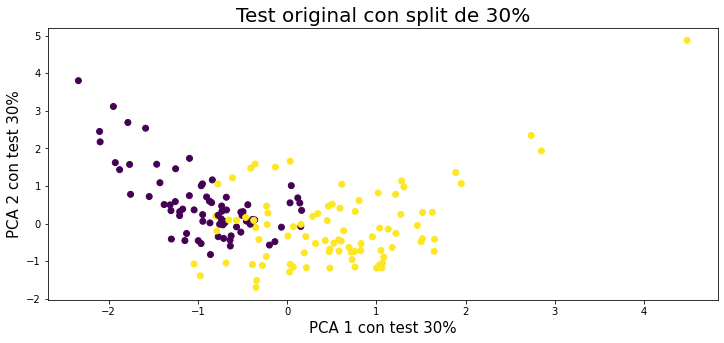

In [28]:
plt.figure(figsize=(12,5))
plt.scatter(X_test[:,0],X_test[:,1],c=y_test)
plt.xlabel("PCA 1 con test 30%",fontsize=15)
plt.ylabel("PCA 2 con test 30%",fontsize=15)
plt.title("Test original con split de 30%",fontsize=20)
plt.show()

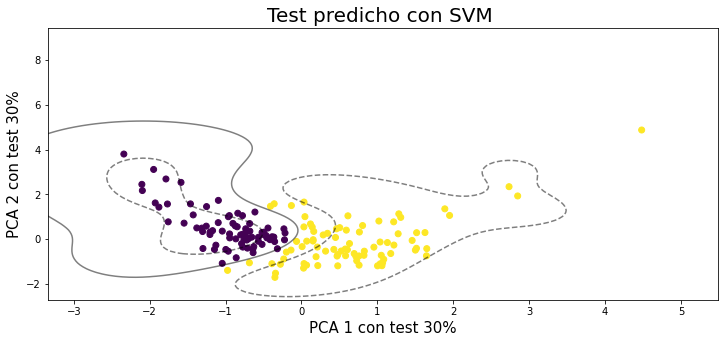

In [29]:
plt.figure(figsize=(12,5))
plt.scatter(X_test[:,0],X_test[:,1],c=y_pred)
plt.xlabel("PCA 1 con test 30%",fontsize=15)
plt.ylabel("PCA 2 con test 30%",fontsize=15)
plt.title("Test predicho con SVM ",fontsize=20)

# w = classifier.coef_[0]
# a = -w[0] / w[1]
# xx = np.linspace(-2.5, 2.5)
# yy = a * xx - (classifier.intercept_[0]) / w[1]
# Plot the hyperplane
#plt.plot(xx, yy)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    classifier,
    X_test,
    plot_method="contour",
    colors="k",
    levels=[-1, 0,1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    classifier.support_vectors_[:, 0],
    classifier.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="none",
)

plt.show()

In [30]:
#Matriz de confución
Matriz_confusion = confusion_matrix(y_test,y_pred)
print("Matriz de confusión:", Matriz_confusion)
# Imprimir precision
Accuracy= accuracy_score(y_test,y_pred)
print("Accuracy: ",Accuracy)
# Recall, sensibilidad
Sensibilidad = recall_score(y_test, y_pred)
print("Sensibilidad: ", Sensibilidad)
#Precisión
Precision = precision_score(y_test, y_pred)
print("Precisión: ",Precision)
#Especificidad
Especificidad = specifity(Matriz_confusion)
print("Especificidad: ", Especificidad)

Matriz de confusión: [[64  9]
 [14 74]]
Accuracy:  0.8571428571428571
Sensibilidad:  0.8409090909090909
Precisión:  0.891566265060241
Especificidad:  0.8205128205128205


### SVM usando K-folds

In [31]:
#Numero de K-folds a usar
kf = KFold(n_splits=10,shuffle=True)
kf.get_n_splits(pca_transformado)

# Arrays para metricas
Accuracy=np.array([])
Sensibilidad = np.array([])
Precision=np.array([])
Especificidad = np.array([])

for train_index, test_index in kf.split(pca_transformado):
    #Vector x (datos)
    X_train, X_test = pca_transformado[train_index], pca_transformado[test_index]
    
    #Vector Y (labels)
    y_train, y_test = labels_data[train_index], labels_data[test_index]

    scaler.fit(X_train)# se calcula los vectores de media  y std

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Crear SVM
    classifier= svm.SVC(kernel='rbf') # Linear Kernel

    #Entrenar el modelo
    classifier.fit(X_train, y_train)

    #predecir los datos para mi data
    y_pred = classifier.predict(X_test)
    
    #Llenar métricas 
    Accuracy=np.append(Accuracy,accuracy_score(y_test,y_pred))
    Sensibilidad= np.append(Sensibilidad,recall_score(y_test, y_pred))
    Precision = np.append(Precision,precision_score(y_test, y_pred))
    Especificidad=np.append(Especificidad,specifity(confusion_matrix(y_test,y_pred)))
    
    #

In [32]:
print("El promedio de accuracy: ",np.mean(Accuracy),",La desviasión estandar: ",np.std(Accuracy))
print("El promedio de la sensibilidad: ",np.mean(Sensibilidad),",La desviasión estandar: ",np.std(Sensibilidad))
print("El promedio de Precisión: ",np.mean(Precision),",La desviasión estandar: ",np.std(Precision))
print("El promedio de Especificidad: ",np.mean(Especificidad),",La desviasión estandar: ",np.std(Especificidad))

El promedio de accuracy:  0.8728860936408106 ,La desviasión estandar:  0.05198870245747914
El promedio de la sensibilidad:  0.8875510712771412 ,La desviasión estandar:  0.06943970874204804
El promedio de Precisión:  0.8988638013104332 ,La desviasión estandar:  0.08427331829006368
El promedio de Especificidad:  0.8470358868184956 ,La desviasión estandar:  0.09664879525972095


## SVM usando Gridsearch y K-fold

In [33]:
#Numero de K-folds a usar
kf = KFold(n_splits=10,shuffle=True)
kf.get_n_splits(pca_transformado)

# Arrays para metricas
Accuracy=np.array([])
Sensibilidad = np.array([])
Precision=np.array([])
Especificidad = np.array([])

#Parametros para evaluar en la malla de busqueda
parameter_svm={"C":[0.0001,.001, 0.01, 0.1, 1, 10, 100],"gamma":[0.0001,.001, 0.01, 0.1, 1, 10, 100]}

#Arrays para guardar parametros en cada fold
C=np.array([])
gamma=np.array([])

#Guardar lso scores
Scores = np.array([]) # Score total 
y_Tpred = np.array([]) #Total de predicciones

for train_index, test_index in kf.split(pca_transformado):
    #Vector x (datos)
    X_train, X_test = pca_transformado[train_index], pca_transformado[test_index]
    
    #Vector Y (labels)
    y_train, y_test = labels_data[train_index], labels_data[test_index]

    scaler.fit(X_train)# se calcula los vectores de media  y std

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Hago la malla de busqueda
    classifier = GridSearchCV(svm.SVC(kernel='rbf'), parameter_svm)
    
    #Entrenar el modelo para poder encontrar mejor C y Gamma
    classifier.fit(X_train, y_train)

    #Llenar parametros C y gamma para cada fold
    C=np.append(C,classifier.best_estimator_.C)
    gamma=np.append(gamma,classifier.best_estimator_.gamma)
    
    #Generar SVM con C y gamma de la mmala de busqueda 
    classifier= svm.SVC(kernel='rbf',C=classifier.best_estimator_.C,gamma=classifier.best_estimator_.gamma) 
    
    #Entrenar el modelo
    classifier.fit(X_train, y_train)

    #predecir los datos para mi data
    y_pred = classifier.predict(X_test)

    #Llenar métricas 
    Accuracy=np.append(Accuracy,accuracy_score(y_test,y_pred))
    Sensibilidad= np.append(Sensibilidad,recall_score(y_test, y_pred))
    Precision = np.append(Precision,precision_score(y_test, y_pred))
    Especificidad=np.append(Especificidad,specifity(confusion_matrix(y_test,y_pred)))
    
    #Scores
    Scores = np.concatenate((Scores,classifier.decision_function(X_test)),axis=0)
    y_Tpred = np.concatenate((y_Tpred,y_test),axis=0)

In [34]:
print("El promedio de accuracy: ",np.mean(Accuracy),",La desviasión estandar: ",np.std(Accuracy))
print("El promedio de la sensibilidad: ",np.mean(Sensibilidad),",La desviasión estandar: ",np.std(Sensibilidad))
print("El promedio de Precisión: ",np.mean(Precision),",La desviasión estandar: ",np.std(Precision))
print("El promedio de Especificidad: ",np.mean(Especificidad),",La desviasión estandar: ",np.std(Especificidad))

El promedio de accuracy:  0.8636268343815514 ,La desviasión estandar:  0.045499867395851136
El promedio de la sensibilidad:  0.8636174252908123 ,La desviasión estandar:  0.05098133605195839
El promedio de Precisión:  0.9013613139670278 ,La desviasión estandar:  0.059522937018141875
El promedio de Especificidad:  0.8167964483181874 ,La desviasión estandar:  0.06849291614723353


In [35]:
print("El vector de los valores C para cada fold:",C, ", La moda es: ", st.mode(C))
print("El vector de los valores gamma para cada fold:",gamma," La moda es: ", st.mode(gamma))

El vector de los valores C para cada fold: [100.   10.  100.    1.  100.  100.    0.1 100.   10.  100. ] , La moda es:  ModeResult(mode=array([100.]), count=array([6]))
El vector de los valores gamma para cada fold: [1.  0.1 1.  1.  1.  1.  1.  1.  1.  1. ]  La moda es:  ModeResult(mode=array([1.]), count=array([9]))


In [36]:
print("El vector de Score: ", Scores)
print("El vector prediccion total: ",y_Tpred)

El vector de Score:  [ 1.31354262 -0.06465903 -1.08371481  0.38757734 -0.75932325 -1.55030794
 -0.64966079  0.33501193  1.10525719  0.64575688 -1.89042087 -1.54399944
 -0.99550758 -0.56199092 -4.18897381 -2.30466179 -0.99148382 -0.03244602
 -0.30855075  1.4462618   0.74528412 -1.01183293  1.67643344  1.81644833
  0.38416868  2.3912772   1.46847873  1.46275151  1.27674631  3.27586737
  1.8710397   1.07853103  1.02161838  1.15653169  4.6101548   1.71583148
  1.45641429  1.25996561  1.14810097  4.67956558  1.54108127 -1.17825314
 -1.75498617  1.50862801 -0.99378485 -0.71358543  2.90944829  0.52793968
  1.17133611  1.54409065  1.94833719  1.17144145  2.31483496 -1.00071821
 -0.59605773 -1.05289231 -0.55841816 -0.4411615   0.30320926 -1.62879972
  0.068385   -0.68497893 -2.53509989 -1.45374962 -1.75026685 -1.25935715
 -0.57362003 -1.79467735 -0.52881299 -0.59668958 -1.62613723 -0.64163968
 -1.19221952  0.19169175 -0.88271323  2.29694035  2.50642387  2.48383666
  3.0309105   2.29410838  0.63

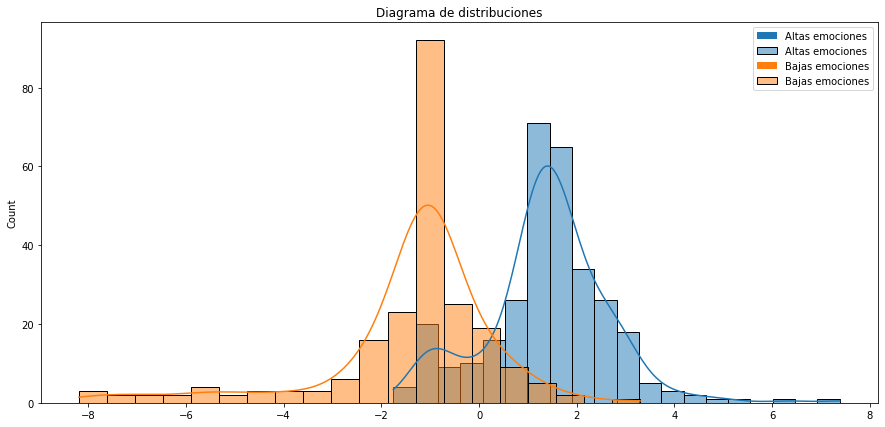

In [37]:
high_Scores = Scores[np.where(y_Tpred==1)]
low_Scores= Scores[np.where(y_Tpred==0)]

plt.figure(figsize=(15,7))
plt.title("Diagrama de distribuciones")
sns.histplot(high_Scores,bins=20,kde=True,label="Altas emociones")
sns.histplot(low_Scores,bins=20,kde=True,label="Bajas emociones")
#eje x distancia al hiperplano
plt.legend()

In [38]:
fp,tp,thresholds = metrics.roc_curve(y_Tpred,Scores)
#Thresholds : Pocision donde se coloca el umbral
print(thresholds)
auc=metrics.auc(fp,tp)

[ 8.38664841  7.38664841  3.40118213  3.29728325  2.14848285  2.14561826
  2.00205023  1.97397966  1.45641429  1.4462618   1.42834212  1.40874148
  1.32723627  1.31354262  1.15324608  1.15154945  1.11525531  1.10525719
  0.89134128  0.88244736  0.79114983  0.76138273  0.74947916  0.74528412
  0.74250902  0.73232473  0.66155511  0.65502874  0.65414806  0.64575688
  0.55907253  0.53378735  0.51706709  0.48720451  0.42497817  0.38757734
  0.38416868  0.38412338  0.36022518  0.30320926  0.29227188  0.28152031
  0.2705186   0.26770549  0.19607515  0.19169175  0.17186054  0.15502459
  0.15150538 -0.03244602 -0.03580914 -0.08818607 -0.09974838 -0.13257792
 -0.26915849 -0.29812021 -0.30250589 -0.30855075 -0.37602635 -0.42260836
 -0.43466757 -0.51430053 -0.52765529 -0.63298959 -0.63711205 -0.7131832
 -0.74663696 -0.74689902 -0.75636256 -0.80164606 -0.82128858 -0.88271323
 -0.88453627 -0.89309089 -0.895119   -0.90286245 -0.90338018 -0.91833448
 -0.92766604 -0.94500793 -0.9457842  -0.9904967  -0.

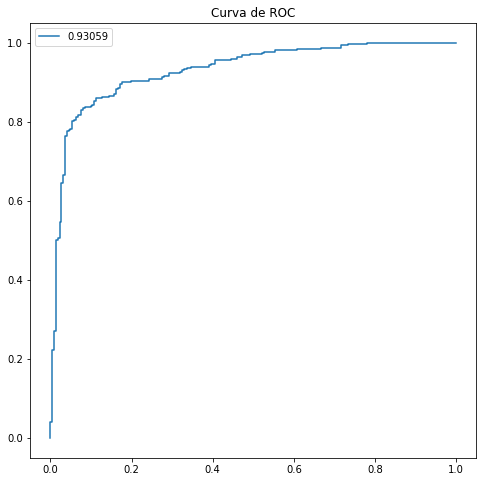

In [39]:
plt.figure(figsize=(8,8)) # la curva ROC siempre es cuadrada
plt.title("Curva de ROC")
plt.plot(fp,tp, label=np.round(auc,6))
plt.legend()

In [40]:
# Sacar diagrama de distribucion de KNN y curva ROC 
# predict_proba(X)
# para KNN es la cantidad de puntos correctos/ N-neighboors
#Audacity